Carl Cook<br>
Flatiron School<br>
Data Science<br>
Online Cohort 081720<br>
Capstone Project - <br>
'Predicting Video Game Ratings Through Image Classification with CNNs'

# Objective

For this project, we are trying to use convolutional neural networks to try to identify the ESRB rating of video games based on images from the game. This could have applications in live content moderation on platforms such as Twitch or YouTube, where a streamer might be streaming games with mature content without identifying their stream as containing mature content. If we can train a CNN to identify mature content or at least flag that content for human review, we can help reduce the amount of content that human reviewers would have to sift through. We could also hopefully identify a greater amount of mature content without the need of user reporting, ideally leading to less consumption by young audiences before the content is reported.

# Obtain

In [1]:
# Imports
import pandas as pd

First, we want a list of games and their respective ratings. We'll pull that information from the ESRB website, and we'll use games released for the PlayStation 4, Xbox One, and Nintendo Switch. The notebook 'data_scrape_titles' details the process of scraping the information using Selenium. A pandas DataFrame containing the data is saved as 'esrb_ratings.pkl'.

In [2]:
df = pd.read_pickle('esrb_ratings.pkl')
df.head()

title  \
0            Blizzard Arcade Collection   
1                          Rez Infinite   
2                        Hotshot Racing   
3  Sea of Solitude : The Director's Cut   
4                               Ape Out   

                                     consoles  \
0  [PlayStation 4, Nintendo Switch, Xbox One]   
1                             [PlayStation 4]   
2            [PlayStation 4, Nintendo Switch]   
3                           [Nintendo Switch]   
4                           [Nintendo Switch]   

                                         descriptors   rating  
0  [Blood, Fantasy Violence, Language, Use of Tob...        T  
1                                 [Fantasy Violence]  E10plus  
2       [Alcohol Reference, Language, Mild Violence]  E10plus  
3                       [Fantasy Violence, Language]        T  
4                         [Blood and Gore, Violence]        T

With this data, we'll use Selenium once again to go through the game titles and pull 10 images of each game from Google Images. This process is detailed in the notebook 'data_scrape_images'. After running the notebook, the images are saved in an 'images' directory, with each image being saved in a subdirectory corresponding to the game's rating.

# Scrub

With our images gathered and sorted, we then run the code in the notebook 'data_split' to split our images into training, validation, and test sets. We do two different splits. In the first split, the game images are sorted according to the specific ratings of their games(E, E10plus, M, T). In the second split, The game images are sorted into groups of E-T and M.

![Image Folder](./project_images/images_folder.png)

The first will allow us to do a 4-class categorical classification. The second will allow us to do a binary classification. Our main goal is to identify M-rated games, and we'll have to see whether a categorical or binary model is better-equipped to do that.

# Explore

In [3]:
# Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

import my_module as custom

C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


To get a feel for the data, we'll create some image generators, and then use that to check out some of our training images.

In [4]:
# Create generators
train_data = ImageDataGenerator(rescale=1/255,
                                horizontal_flip=True,
                                shear_range=0.2,
                                zoom_range=0.2)
val_data = ImageDataGenerator(rescale=1/255)
test_data = ImageDataGenerator(rescale=1/255)

In [5]:
train_gen = train_data.flow_from_directory('images/train', target_size=(224,224))
val_gen = val_data.flow_from_directory('images/val', target_size=(224,224))
test_gen = test_data.flow_from_directory('images/test', target_size=(224,224), shuffle=False)

Found 33620 images belonging to 4 classes.
Found 2240 images belonging to 4 classes.
Found 8970 images belonging to 4 classes.


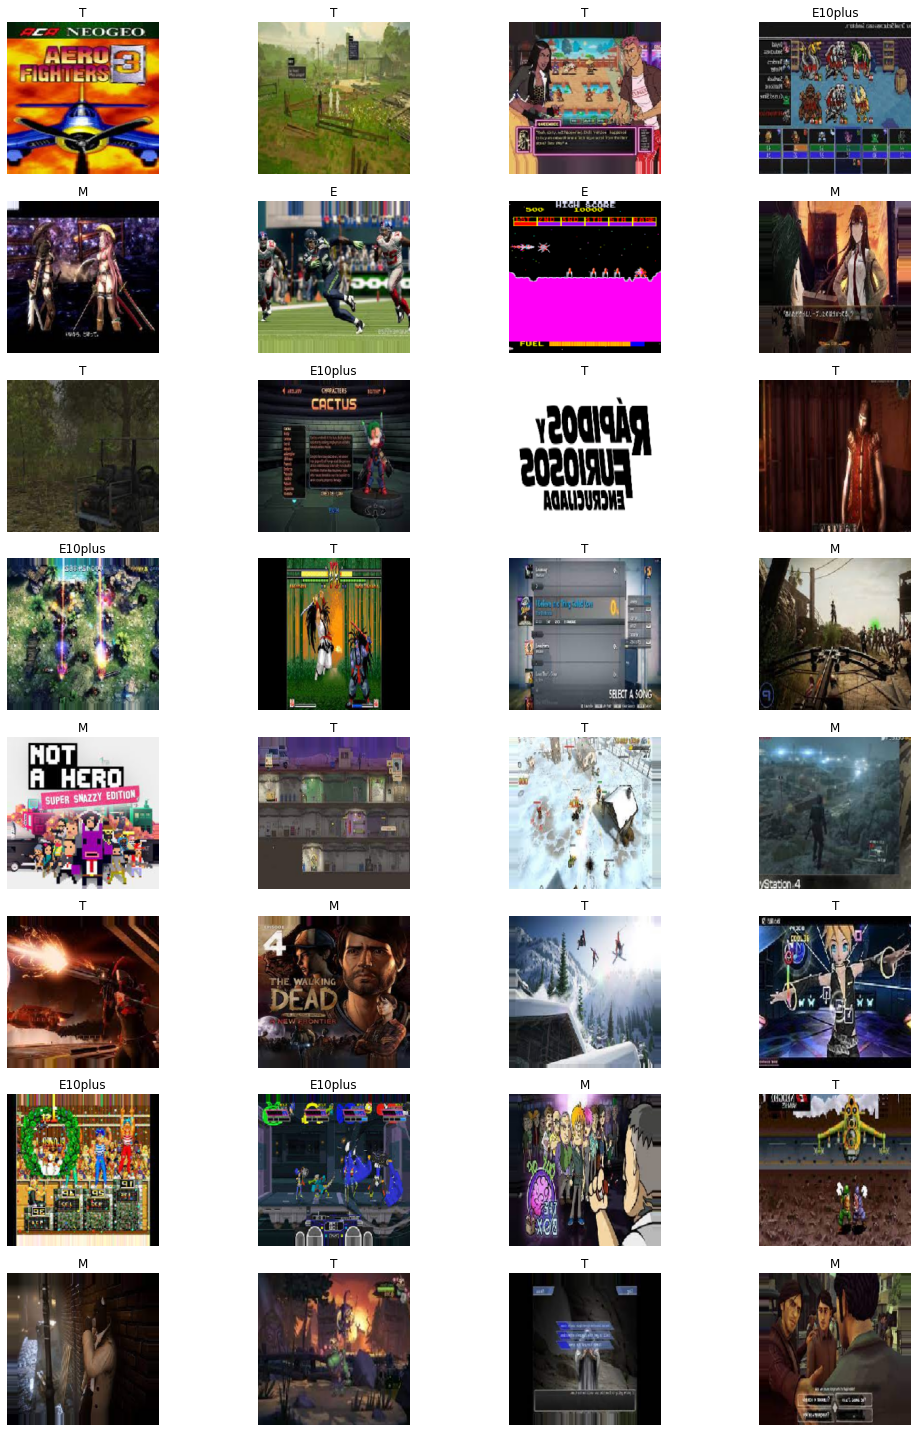

In [6]:
# Get a batch of images
img, labels = train_gen.next()
ratings = ['E', 'E10plus', 'M', 'T']

# Show the images and labels
plt.figure(figsize=(15,20))
for i in range(len(img)):
    plt.subplot(8,4,i+1)
    plt.title(ratings[labels[i].argmax()])
    plt.imshow(img[i])
    plt.axis('off')
plt.tight_layout()

Upon viewing this batch of images, I would not personally be able to accurately label many of the games just based on the given image. Hopefully our neural networks can pick out features that are not obvious to me.

# Model

In [7]:
# Imports
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

Before modeling, we'll use a simple function to save our best model weights in case we need to revert back to them later.

In [8]:
def init_callbacks(number):
    model_checkpoint = ModelCheckpoint(f'best_model_{str(number)}.h5', monitor='val_loss',
                                       verbose=1, save_best_only=True,
                                       save_weights_only=True)
    return model_checkpoint

epochs = 10
input_shape = (224,224,3)

## Model 1 (Simple Neural Network)

Our first model is just a simple neural network with a couple of dense layers and an output layer. This neural net probably lacks the complexity to make good predictions for our particular case, but if nothing else it provides a decent baseline for determining whether or not future models are an improvement.

In [9]:
model_1 = Sequential()
model_1.add(Dense(128, activation='relu', input_shape=input_shape))
model_1.add(Dense(64, activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(4, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                metrics=['acc'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 128)     512       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      8256      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 12845060  
Total params: 12,853,828
Trainable params: 12,853,828
Non-trainable params: 0
_________________________________________________________________


In [10]:
history_1 = model_1.fit(train_gen,
                        steps_per_epoch=100,
                        epochs=epochs,
                        validation_data=val_gen,
                        callbacks=init_callbacks(1))

Epoch 1/10
100/100 [==============================] - 32s 307ms/step - loss: 4.7256 - acc: 0.2689 - val_loss: 1.9811 - val_acc: 0.3478

Epoch 00001: val_loss improved from inf to 1.98107, saving model to best_model_1.h5
Epoch 2/10
100/100 [==============================] - 30s 303ms/step - loss: 1.4824 - acc: 0.3331 - val_loss: 1.3180 - val_acc: 0.3737

Epoch 00002: val_loss improved from 1.98107 to 1.31802, saving model to best_model_1.h5
Epoch 3/10
100/100 [==============================] - 31s 304ms/step - loss: 1.3275 - acc: 0.3625 - val_loss: 1.3208 - val_acc: 0.3737

Epoch 00003: val_loss did not improve from 1.31802
Epoch 4/10
100/100 [==============================] - 30s 302ms/step - loss: 1.3074 - acc: 0.3688 - val_loss: 1.3069 - val_acc: 0.3938

Epoch 00004: val_loss improved from 1.31802 to 1.30689, saving model to best_model_1.h5
Epoch 5/10
100/100 [==============================] - 30s 303ms/step - loss: 1.2875 - acc: 0.3912 - val_loss: 1.3009 - val_acc: 0.4013

Epoch 000

### Results

The evaluate function in my_module.py gives us a good deal of information about the model. First, it shows accuracy and loss over each epoch, which is useful in determining whether a model has started to overfit. Since we're only running 10 epochs, this shouldn't be a big concern, but if we see accuracy or loss for our validation set start to go off course at the end of training, we can always revert to the weights saved by our ModelCheckpoint callback.

Next we see a couple of pie charts. The first shows the distribution of classes in the test set, and the second shows the distribution of classes in the model's predictions for the test set. While similar distributions don't necessarily mean that our model is performing well, it does help us to see if biases in our model may need to be offset.

Next is a very nice confusion matrix plot by Wagner Cipriano. It shows both the true numbers and overall percentage for each prediction as well as showing accuracy and recall right on the confusion matrix.

While the confusion matrix makes the classification report largely unnecessary, I do like having it to see the f1 score for the M-rated class. As this project is mostly about being able to identify these M-rated games, a model with high recall on the M class is preferable. However, if that high recall comes at the cost of an overly poor precision, it defeats the purpose of the model, as the model would cause a lot of unnecessary human review.

281/281 [==============================] - 21s 75ms/step - loss: 1.3041 - acc: 0.3970
[1.3041287660598755, 0.39698997139930725]


C:\Users\katma\course_materials\capstone-project\my_module.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(1,(len(history['acc']))+1),5)
C:\Users\katma\course_materials\capstone-project\my_module.py:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(range(1,(len(history['loss']))+1),5)


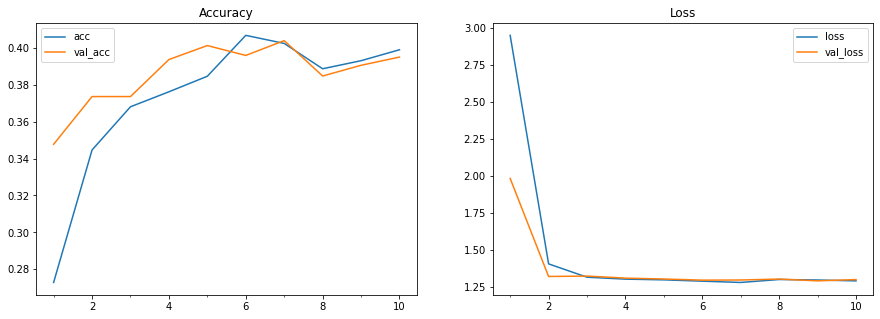

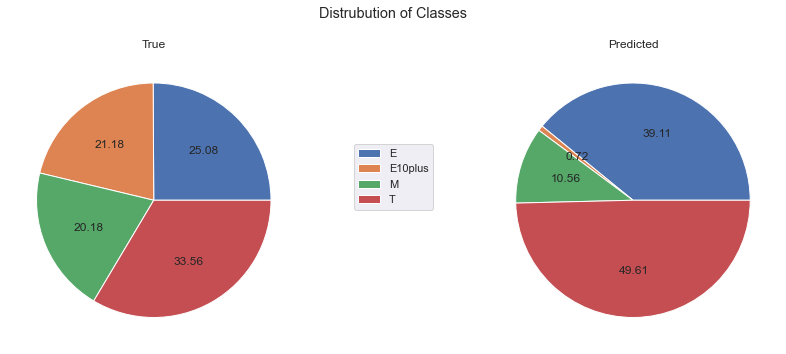

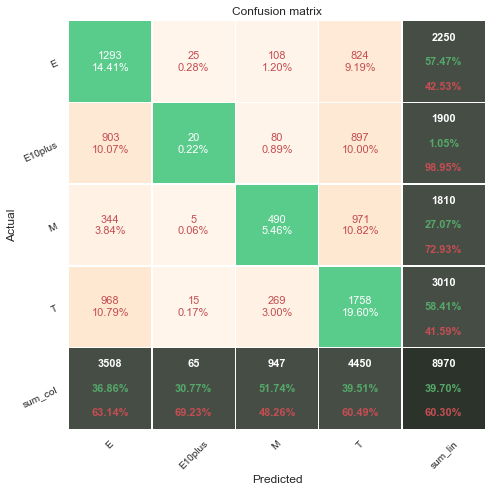

              precision    recall  f1-score   support

           E       0.37      0.57      0.45      2250
     E10plus       0.31      0.01      0.02      1900
           M       0.52      0.27      0.36      1810
           T       0.40      0.58      0.47      3010

    accuracy                           0.40      8970
   macro avg       0.40      0.36      0.32      8970
weighted avg       0.39      0.40      0.35      8970



<Figure size 432x288 with 0 Axes>

In [11]:
custom.evaluate(model_1, history_1, test_gen)

We can see that this model is definitely biased toward E and T predictions. Understandable, as those are the two most prominent classes. This model gives us only 27% recall for the M class, making it pretty ineffective at identifying M-rated games based on screenshots.

## Model 2 (CNN - 4 Convolutional Blocks)

As the simple neural network proved ineffective, we'll move on to a convolutional neural network. CNNs are often used for image classification projects as the convolutional layers are much better than dense layers at discovering patterns in images. This model uses four convolutional blocks, each containing two Conv2D layers and a MaxPooling2D layer. Each block also includes a Dropout layer, which helps prevent overfitting. After the convolutional blocks, we flatten the inputs and pass them to a Dense layer before outputting predictions.

In [12]:
model_2 = Sequential()

model_2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                  activation='relu', input_shape=input_shape))
model_2.add(Conv2D(32, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_2.add(Conv2D(128, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_2.add(Conv2D(256, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(4, activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)       

In [13]:
history_2 = model_2.fit(train_gen,
                        epochs=epochs,
                        validation_data=val_gen,
                        callbacks=init_callbacks(2))

Epoch 1/10
1051/1051 [==============================] - 274s 255ms/step - loss: 1.3243 - acc: 0.3528 - val_loss: 1.2697 - val_acc: 0.4009

Epoch 00001: val_loss improved from inf to 1.26973, saving model to best_model_2.h5
Epoch 2/10
1051/1051 [==============================] - 261s 248ms/step - loss: 1.2505 - acc: 0.4110 - val_loss: 1.2465 - val_acc: 0.4232

Epoch 00002: val_loss improved from 1.26973 to 1.24649, saving model to best_model_2.h5
Epoch 3/10
1051/1051 [==============================] - 263s 250ms/step - loss: 1.2246 - acc: 0.4267 - val_loss: 1.2353 - val_acc: 0.4254

Epoch 00003: val_loss improved from 1.24649 to 1.23527, saving model to best_model_2.h5
Epoch 4/10
1051/1051 [==============================] - 259s 246ms/step - loss: 1.2126 - acc: 0.4465 - val_loss: 1.2360 - val_acc: 0.4268

Epoch 00004: val_loss did not improve from 1.23527
Epoch 5/10
1051/1051 [==============================] - 260s 247ms/step - loss: 1.1934 - acc: 0.4533 - val_loss: 1.2756 - val_acc: 0.

### Results

281/281 [==============================] - 12s 41ms/step - loss: 1.1915 - acc: 0.4702
[1.1915004253387451, 0.47023412585258484]


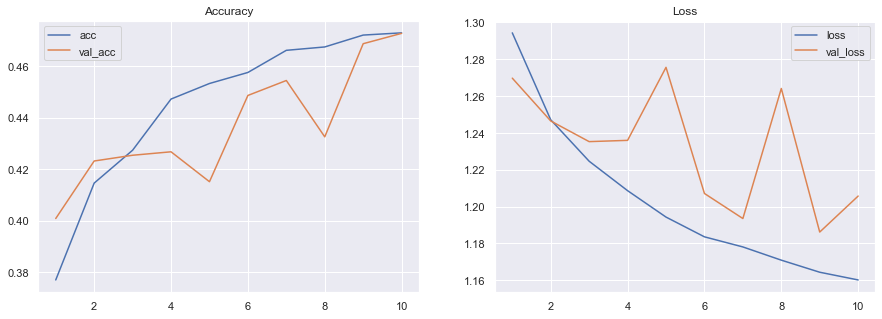

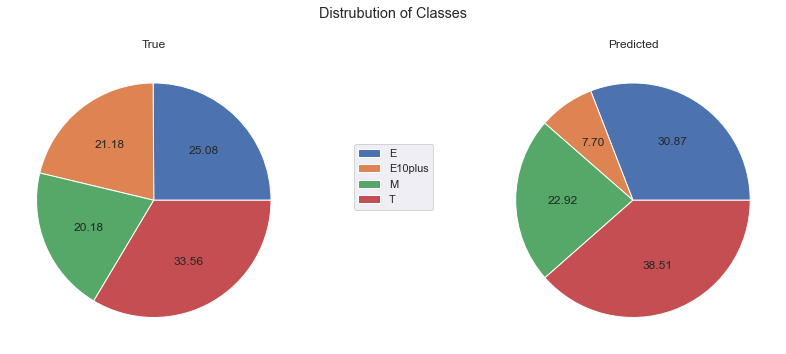

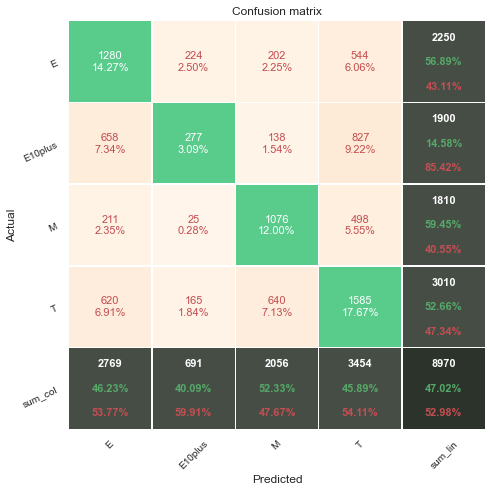

              precision    recall  f1-score   support

           E       0.46      0.57      0.51      2250
     E10plus       0.40      0.15      0.21      1900
           M       0.52      0.59      0.56      1810
           T       0.46      0.53      0.49      3010

    accuracy                           0.47      8970
   macro avg       0.46      0.46      0.44      8970
weighted avg       0.46      0.47      0.45      8970



<Figure size 432x288 with 0 Axes>

In [14]:
custom.evaluate(model_2, history_2, test_gen)

Our accuracy improved quite a bit with this model, and we can see from the pie charts that the distributions are much closer than last time, although this model still does have a bit of an aversion to the E10plus class. We've also reached 59% recall on the M class with 52% precision. That's a big improvement. In fact, the M class has the highest f1 score in this model at 0.56.

## Model 3 (With Class Weights)

While our last model showed good improvement, we might be able to further improve by adding class weights to the model. While our data isn't terribly imbalanced, we have seen that our models do have some bias toward the more prominent classes. We'll use the same model structure as last time, except this time we're adding a BatchNormalization layer to each convolutional block and adding a class_weight argument to the compile function.

In [15]:
model_3 = Sequential()

model_3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                  activation='relu', input_shape=input_shape))
model_3.add(Conv2D(32, (3,3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model_3.add(Conv2D(64, (3,3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_3.add(Conv2D(128, (3,3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_3.add(Conv2D(256, (3,3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2,2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(4, activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model_3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 64)     

In [16]:
class_counts = [11240, 9480, 15070, 9040]
class_weights = {x:15070/y for x,y in enumerate(class_counts)}

In [17]:
history_3 = model_3.fit(train_gen,
                        epochs=epochs,
                        validation_data=val_gen,
                        callbacks=init_callbacks(3),
                        class_weight=class_weights)

Epoch 1/10
1051/1051 [==============================] - 262s 248ms/step - loss: 3.1996 - acc: 0.3258 - val_loss: 1.7291 - val_acc: 0.3754

Epoch 00001: val_loss improved from inf to 1.72911, saving model to best_model_3.h5
Epoch 2/10
1051/1051 [==============================] - 262s 249ms/step - loss: 1.8292 - acc: 0.3781 - val_loss: 2.1966 - val_acc: 0.3308

Epoch 00002: val_loss did not improve from 1.72911
Epoch 3/10
1051/1051 [==============================] - 264s 251ms/step - loss: 1.8037 - acc: 0.3859 - val_loss: 1.3647 - val_acc: 0.3951

Epoch 00003: val_loss improved from 1.72911 to 1.36467, saving model to best_model_3.h5
Epoch 4/10
1051/1051 [==============================] - 263s 250ms/step - loss: 1.7846 - acc: 0.4014 - val_loss: 1.4402 - val_acc: 0.3987

Epoch 00004: val_loss did not improve from 1.36467
Epoch 5/10
1051/1051 [==============================] - 261s 248ms/step - loss: 1.7649 - acc: 0.4119 - val_loss: 1.3330 - val_acc: 0.4192

Epoch 00005: val_loss improved 

### Results

281/281 [==============================] - 12s 42ms/step - loss: 1.2418 - acc: 0.4486
[1.2417646646499634, 0.4486064612865448]


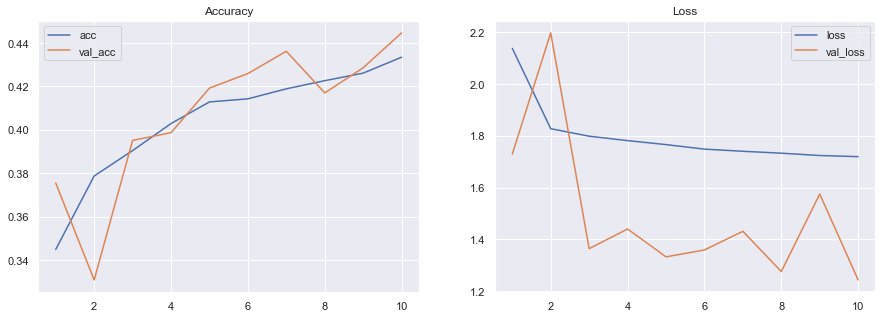

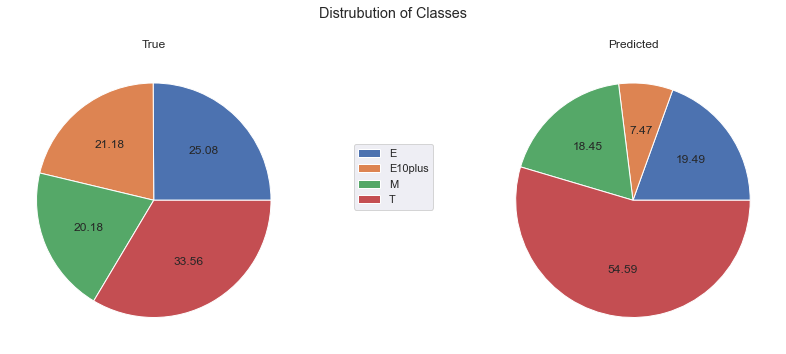

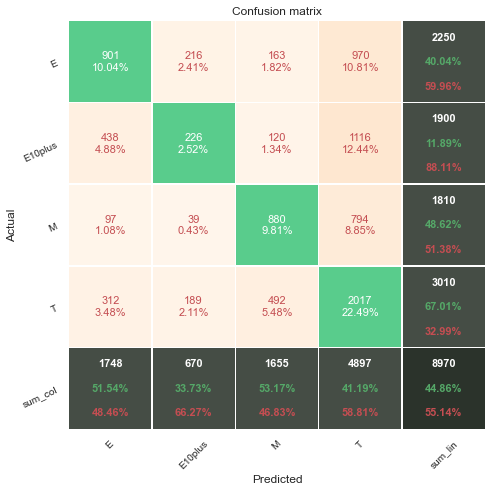

              precision    recall  f1-score   support

           E       0.52      0.40      0.45      2250
     E10plus       0.34      0.12      0.18      1900
           M       0.53      0.49      0.51      1810
           T       0.41      0.67      0.51      3010

    accuracy                           0.45      8970
   macro avg       0.45      0.42      0.41      8970
weighted avg       0.45      0.45      0.42      8970



<Figure size 432x288 with 0 Axes>

In [18]:
custom.evaluate(model_3, history_3, test_gen)

Our overall accuracy went down by a couple percentage points with this model, but the accuracy and loss charts show that this model could probably do with some further training. Looking at the pie charts, it looks like adding class weights had the opposite of our intended effect, with the T class taking over the majority of predictions. We also lost almost 12% on recall for the M class. This is definitely not an improvement on our second model.

## Model 4 (Pretrained CNN)

One of the great things about using CNNs for image classification is that a bunch of other data scientists have done it already. As such, there are several pretrained CNN architectures available. For this model, we'll use the VGG-16 architecture, which is available for import straight from Keras. We'll keep the VGG-16 layers untrainable, but we'll add a few layers at the end of the model to allow the model to shape itself to our particular data.

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape=input_shape,
                   include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

model_4 = Model(base_model.input, x)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model_4.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['acc'])

model_4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
history_4 = model_4.fit(train_gen,
                        validation_data=val_gen,
                        epochs=epochs,
                        callbacks=init_callbacks(4))

Epoch 1/10
1051/1051 [==============================] - 282s 263ms/step - loss: 1.3727 - acc: 0.3905 - val_loss: 1.1799 - val_acc: 0.4929

Epoch 00001: val_loss improved from inf to 1.17991, saving model to best_model_4.h5
Epoch 2/10
1051/1051 [==============================] - 273s 259ms/step - loss: 1.1994 - acc: 0.4591 - val_loss: 1.1515 - val_acc: 0.4938

Epoch 00002: val_loss improved from 1.17991 to 1.15154, saving model to best_model_4.h5
Epoch 3/10
1051/1051 [==============================] - 283s 269ms/step - loss: 1.1717 - acc: 0.4709 - val_loss: 1.1568 - val_acc: 0.5080

Epoch 00003: val_loss did not improve from 1.15154
Epoch 4/10
1051/1051 [==============================] - 274s 261ms/step - loss: 1.1678 - acc: 0.4751 - val_loss: 1.1413 - val_acc: 0.5085

Epoch 00004: val_loss improved from 1.15154 to 1.14128, saving model to best_model_4.h5
Epoch 5/10
1051/1051 [==============================] - 280s 266ms/step - loss: 1.1532 - acc: 0.4875 - val_loss: 1.1304 - val_acc: 0.

### Results

281/281 [==============================] - 43s 152ms/step - loss: 1.1392 - acc: 0.5108
[1.139237880706787, 0.51081383228302]


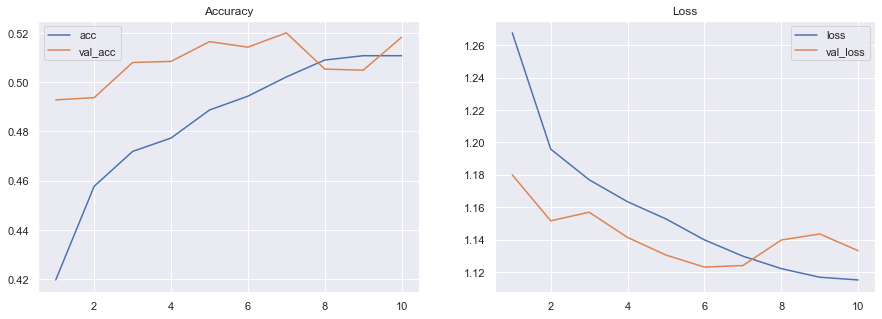

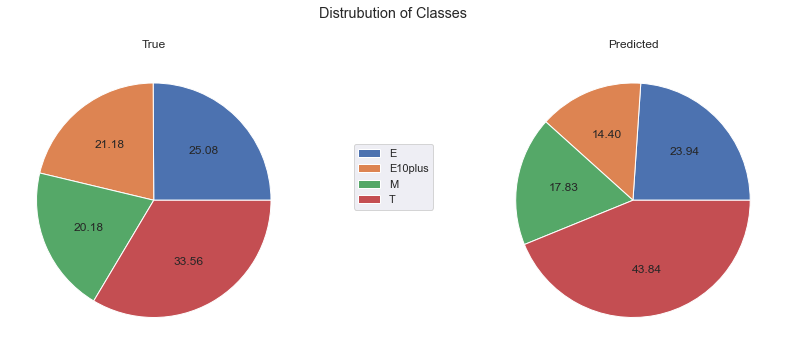

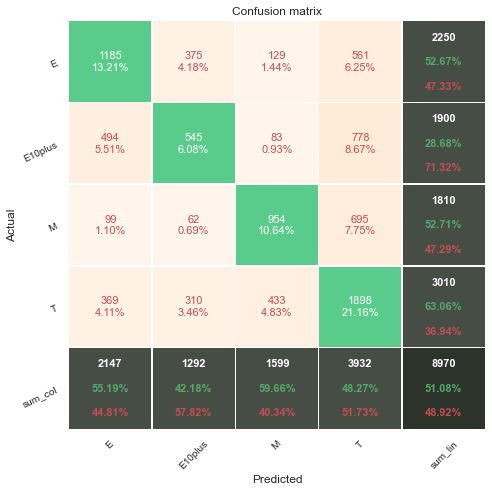

              precision    recall  f1-score   support

           E       0.55      0.53      0.54      2250
     E10plus       0.42      0.29      0.34      1900
           M       0.60      0.53      0.56      1810
           T       0.48      0.63      0.55      3010

    accuracy                           0.51      8970
   macro avg       0.51      0.49      0.50      8970
weighted avg       0.51      0.51      0.50      8970



<Figure size 432x288 with 0 Axes>

In [21]:
custom.evaluate(model_4, history_4, test_gen)

And with that, we've finally broken above 50% overall accuracy! The class distributions look decent as well, although still about 10% heavy on the T predictions and 6% light on E10plus. Our M class recall is about 53% with 60% precision, giving us an f1 score of 0.56, similar to our first CNN model. It's a close call on which model is preferable.

## Model 5 (Binary)

Since the main concern of this project is identifying M-rated games, it seems reasonable that a binary approach could prove effective. By combining all of the data for classes E-T, we could train a model to simply pull the M-rated games from the rest. This will, however, drastically alter the class imbalance problem. Allowing for class weights did not help us in the past, but in this case the imbalance will be too great to ignore.

In [22]:
train_gen_bin = train_data.flow_from_directory('images/binary/train', 
                                               target_size=(224,224),
                                               class_mode='binary')
val_gen_bin = val_data.flow_from_directory('images/binary/val', 
                                           target_size=(224,224),
                                           class_mode='binary')
test_gen_bin = test_data.flow_from_directory('images/binary/test',
                                             target_size=(224,224),
                                             class_mode='binary',
                                             shuffle=False)

Found 33598 images belonging to 2 classes.
Found 2240 images belonging to 2 classes.
Found 8970 images belonging to 2 classes.


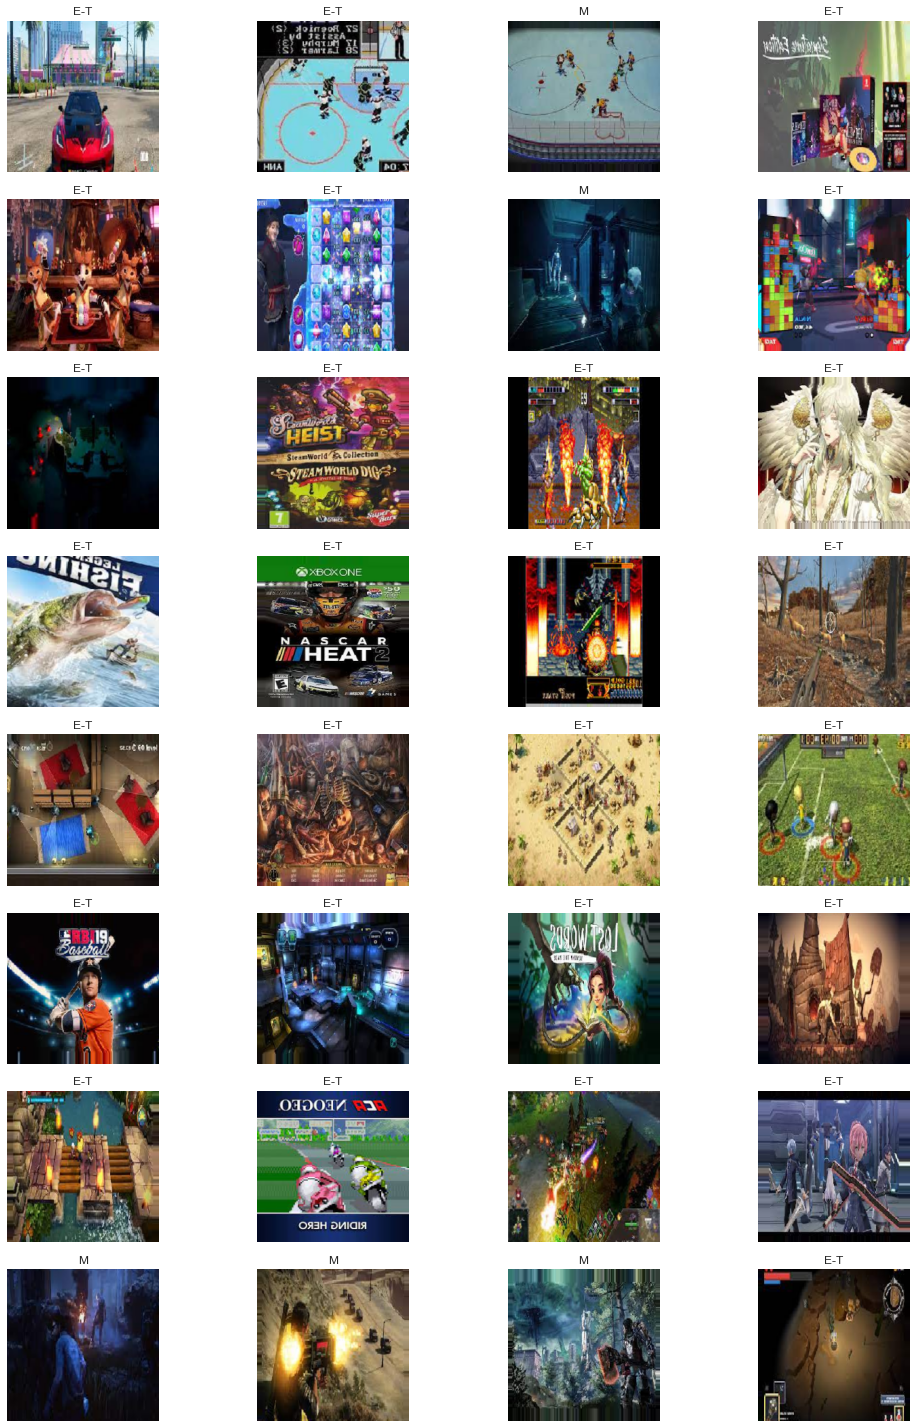

In [23]:
# View a batch of binary train data
img, labels = train_gen_bin.next()
classes = list(train_gen_bin.class_indices.keys())
str_labels = [classes[x] for x in labels.astype('int')]

plt.figure(figsize=(15,20))
for i in range(len(img)):
    plt.subplot(8,4,i+1)
    plt.title(f'{str_labels[i]}')
    plt.imshow(img[i])
    plt.axis('off')
plt.tight_layout()

In [24]:
base_model_bin = VGG16(include_top=False,
                       input_shape=input_shape)
for layer in base_model_bin.layers:
    layer.trainable = False
    
x = Flatten()(base_model_bin.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model_5 = Model(base_model_bin.input, x)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_5.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['acc'])

model_5.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [25]:
total = train_gen_bin.classes.shape[0]
ones = train_gen_bin.classes.sum()
zeroes = total - ones

print(zeroes, ones)

26818 6780


In [26]:
class_weights = {x:zeroes/y for x,y in enumerate([zeroes, ones])}
class_weights

{0: 1.0, 1: 3.955457227138643}

In [27]:
history_5 = model_5.fit(train_gen_bin,
                        validation_data=val_gen_bin,
                        epochs=epochs,
                        class_weight=class_weights,
                        callbacks=init_callbacks(5))

Epoch 1/10
1050/1050 [==============================] - 288s 274ms/step - loss: 0.9863 - acc: 0.6795 - val_loss: 0.5429 - val_acc: 0.7433

Epoch 00001: val_loss improved from inf to 0.54288, saving model to best_model_5.h5
Epoch 2/10
1050/1050 [==============================] - 272s 259ms/step - loss: 0.8701 - acc: 0.7344 - val_loss: 0.5015 - val_acc: 0.7674

Epoch 00002: val_loss improved from 0.54288 to 0.50150, saving model to best_model_5.h5
Epoch 3/10
1050/1050 [==============================] - 271s 258ms/step - loss: 0.8259 - acc: 0.7506 - val_loss: 0.5677 - val_acc: 0.7196

Epoch 00003: val_loss did not improve from 0.50150
Epoch 4/10
1050/1050 [==============================] - 273s 260ms/step - loss: 0.8120 - acc: 0.7552 - val_loss: 0.4883 - val_acc: 0.7688

Epoch 00004: val_loss improved from 0.50150 to 0.48831, saving model to best_model_5.h5
Epoch 5/10
1050/1050 [==============================] - 271s 258ms/step - loss: 0.8045 - acc: 0.7570 - val_loss: 0.4253 - val_acc: 0.

### Results

281/281 [==============================] - 40s 143ms/step - loss: 0.5416 - acc: 0.7446
[0.5415802001953125, 0.74459308385849]


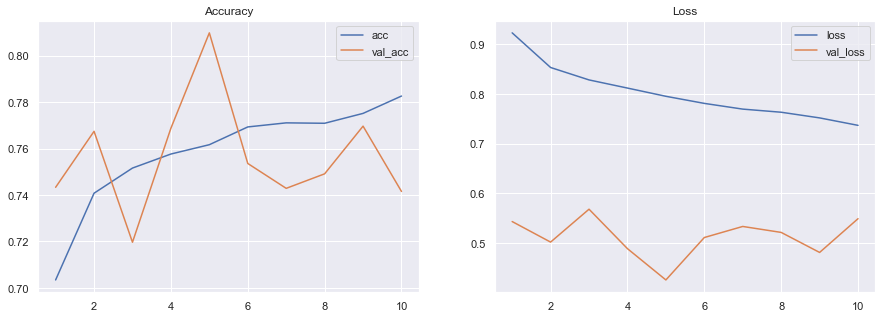

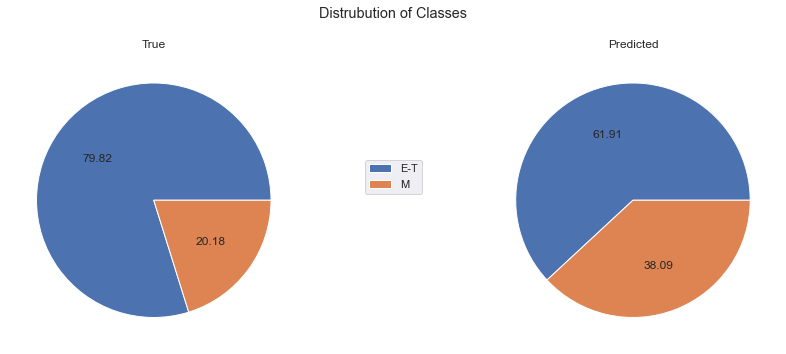

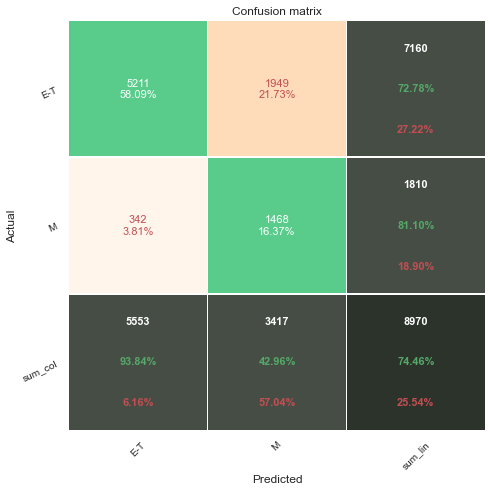

              precision    recall  f1-score   support

         E-T       0.94      0.73      0.82      7160
           M       0.43      0.81      0.56      1810

    accuracy                           0.74      8970
   macro avg       0.68      0.77      0.69      8970
weighted avg       0.84      0.74      0.77      8970



<Figure size 432x288 with 0 Axes>

In [28]:
custom.evaluate(model_5, history_5, test_gen_bin)

We ended up with an overall accuracy of about 74%, and while that sounds much higher than the previous models, it's worth remembering that only about 20% of the images are M class. The model could achieve 80% accuracy by simply predicting the majority class for every prediction. Judging by the pie charts, it looks like adding the class weights definitely gave a healthy boost to M-class predictions. We also achieved an 81% recall on the M class. The precision is only 43%, leaving the f1 score once again at 0.56. I think that boost in recall is too good to pass up, though. Of the five, I would definitely deploy this model. 

# iNterpret

When using neural networks, it can be difficult to see what's happening with the model. What is the model doing with the image data, and what patterns is it finding. Luckily, we can grab the outputs of individual layers and see what that layer has done to our original images. Below, I've put together some code to see the VGG-16 model's interpretations of an image after each of the 5 convolutional blocks. For each block, we see the image altered in 64 different ways to focus on different aspects of the original image.

In [29]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
import numpy as np

In [30]:
model = VGG16()
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

Image from: NBA 2K21
Rated: E


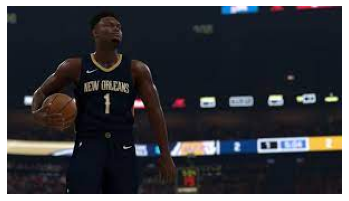

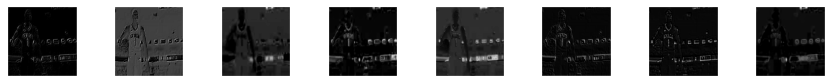

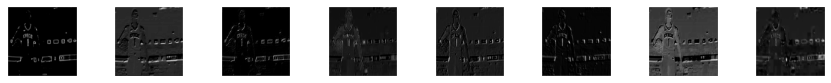

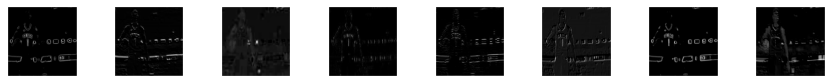

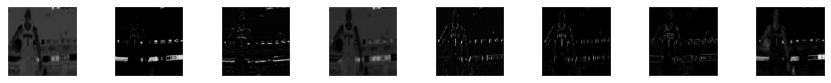

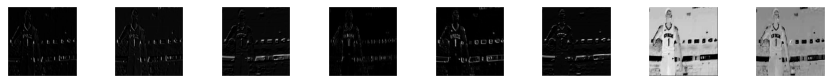

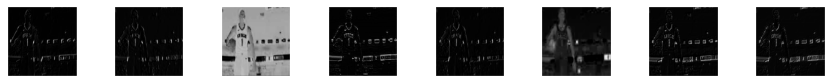

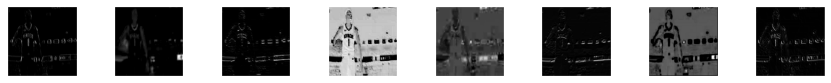

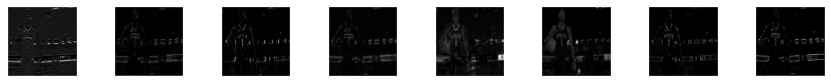

------------------------------------------------------------------------------------------------------------


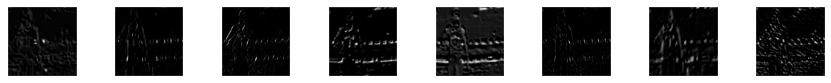

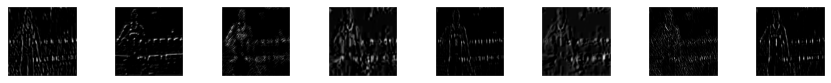

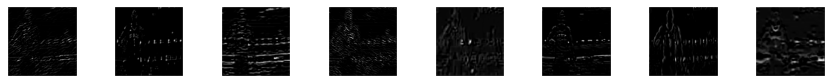

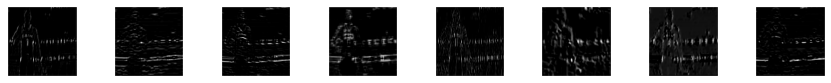

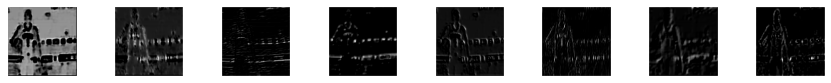

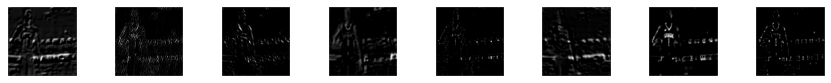

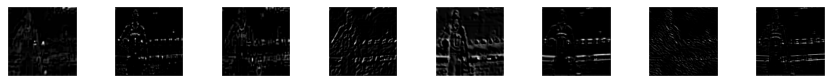

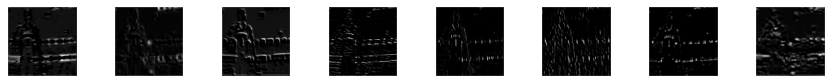

------------------------------------------------------------------------------------------------------------


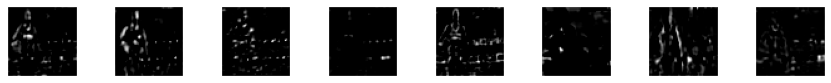

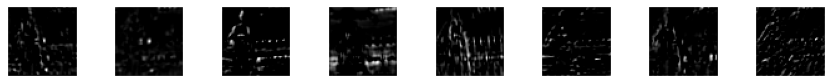

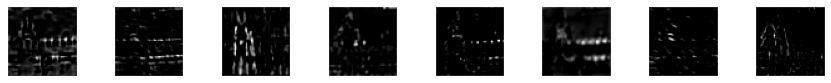

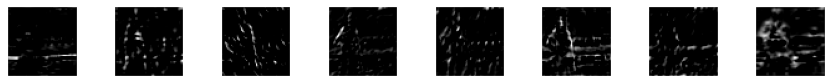

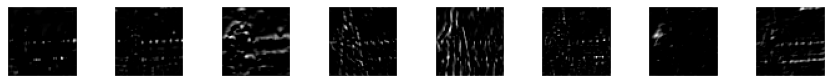

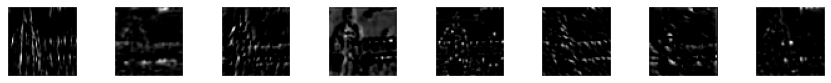

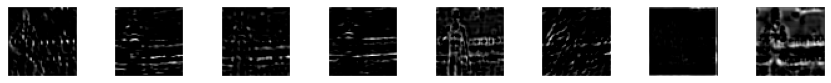

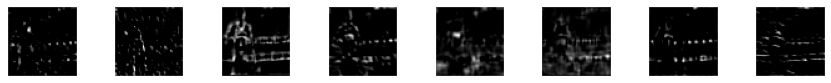

------------------------------------------------------------------------------------------------------------


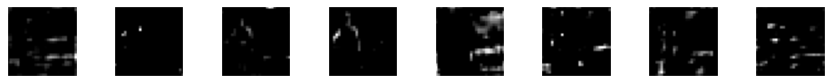

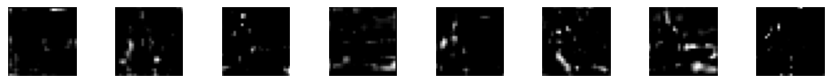

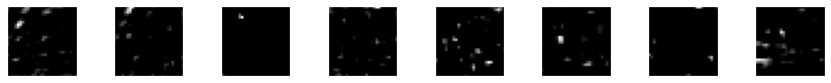

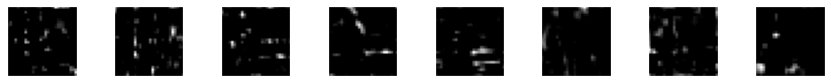

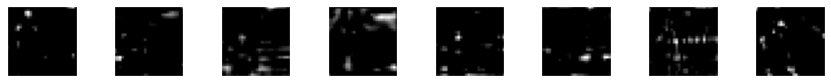

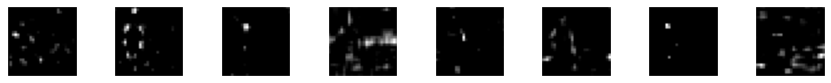

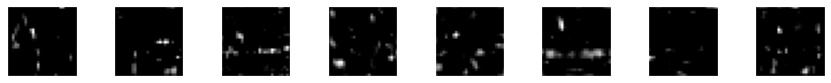

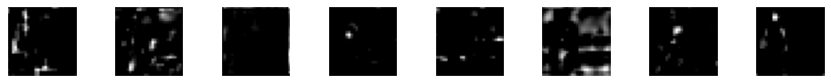

------------------------------------------------------------------------------------------------------------


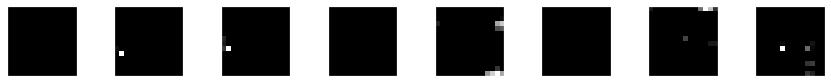

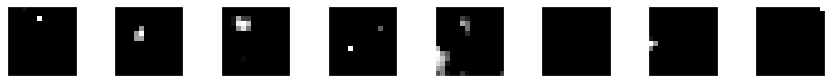

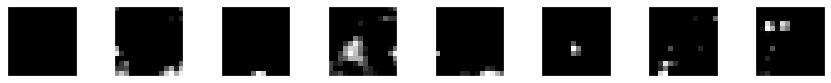

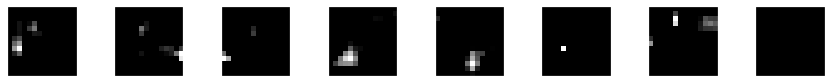

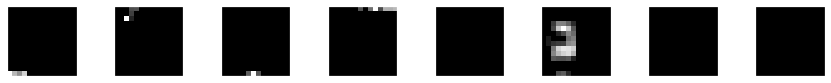

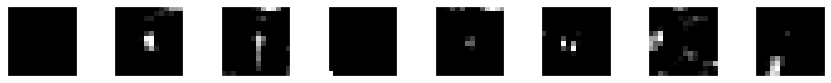

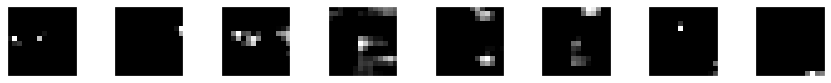

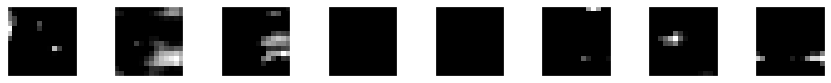

------------------------------------------------------------------------------------------------------------


In [31]:
random_rating = np.random.choice(['E', 'E10plus', 'M', 'T'])
random_image = np.random.choice(os.listdir('images/' + random_rating))
random_path = 'images/' + random_rating + '/' + random_image

test_img = load_img(random_path, target_size=(224,224))
test_img = img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img = preprocess_input(test_img)

feature_maps = model.predict(test_img)

square = 8
print(f'Image from: {random_image[:-6]}')
print(f'Rated: {random_rating}')
plt.imshow(load_img(random_path))
plt.axis('off')
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        plt.figure(figsize=(15,12))
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fmap[0,:,:,ix-1], cmap='gray')
            ix += 1
    plt.show()
    print('-----' * 21 + '---')

In [32]:
model_5.predict(test_img)

array([[0.]], dtype=float32)

Above we can see an image from the game NBA 2K21. The image undergoes many convolutions, and while the image is still quite recognizable in many of the first-layer outputs, it is broken down further and further in subsequent layers. While we may still not be able to make much sense of the patterns that the model is drawing out, we can see in layer 5 that the model has definitely found specifics aspects of the image to focus on. And running this specific image though our binary model's predict function, we can see that our model was able to correctly predict that this is not an M-rated title.

# Conclusion

While the models here are not perfect predictors of M-rated games, we did achieve 81% recall for M-rated games in our binary model. While the precision for this model is too low to implement in any sort of automated content restriction program, I do believe that it could be effective for automated content flagging. This flagged content could then be put up for human review by Twitch, YouTube, or any video game content hosting service.

## Suggestions

* These particular models were trained on data scraped directly from Google Images using the game titles and the keywords 'video game screenshot.' While I did find this to be a fairly reliable source of images, it is certainly not a perfect sampling of data. More reliable data could probably obtained in bulk by the streaming services themselves by grabbing random gameplay screenshots during streams, though this would require confirmation that the pulled images were correctly labeled, and Twitch streamers are not always necessarily playing the game that they indicate they're playing. It would also be more difficult to obtain images from more obscure, less-streamed games.

* I think it could also be effective to stack models to get a single prediction from several screenshots, though my experiments with this so far have not proved to be any more accurate than the models shown here.

* In the same vein as the last suggestion, it might also prove effective to train models on short gameplay video clips rather than single-frame images, though this would certainly involve exponentially greater computational power.